In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

***Initial Observations***

Summary

Data shows some peaks which are located at the closing price.


Data preparation, adding new features to derive observations.

In [7]:
raw_pdf = pd.read_csv('dataKCx.csv')

##Add dummy timestamp
opening_time = pd.Timestamp('06:55:00').strftime("%H:%M:%S")
raw_pdf.loc[raw_pdf['tradingphase'] == 'OPENING AUCTION','time'] = opening_time
closing_time = pd.Timestamp('15:30:00').strftime("%H:%M:%S")
raw_pdf.loc[raw_pdf['tradingphase'] == 'CLOSING AUCTION','time'] = closing_time

c_pdf = raw_pdf[(raw_pdf['tradingphase'] == 'CONTINUOUS') | (raw_pdf['tradingphase'] == 'OPENING AUCTION')]


raw_pdf['date_time'] = pd.to_datetime(raw_pdf['date'] + 'T' + raw_pdf['time'])
raw_pdf.set_index('date_time')


,Unnamed: 0,date,time,volume,tradingphase
date_time,,,,,
2020-03-30 06:55:00,1,2020-03-30,06:55:00,466939.0,OPENING AUCTION
2020-03-30 07:00:00,2,2020-03-30,07:00:00,199240.0,CONTINUOUS
2020-03-30 07:05:00,3,2020-03-30,07:05:00,399928.0,CONTINUOUS
2020-03-30 07:10:00,4,2020-03-30,07:10:00,355929.0,CONTINUOUS
2020-03-30 07:15:00,5,2020-03-30,07:15:00,290592.0,CONTINUOUS
...,...,...,...,...,...
2023-03-08 16:10:00,68324,2023-03-08,16:10:00,589997.0,CONTINUOUS
2023-03-08 16:15:00,68325,2023-03-08,16:15:00,618924.0,CONTINUOUS
2023-03-08 16:20:00,68326,2023-03-08,16:20:00,733780.0,CONTINUOUS


First look at the data shows some peaks at regular intervals that corresponds to the closing price.

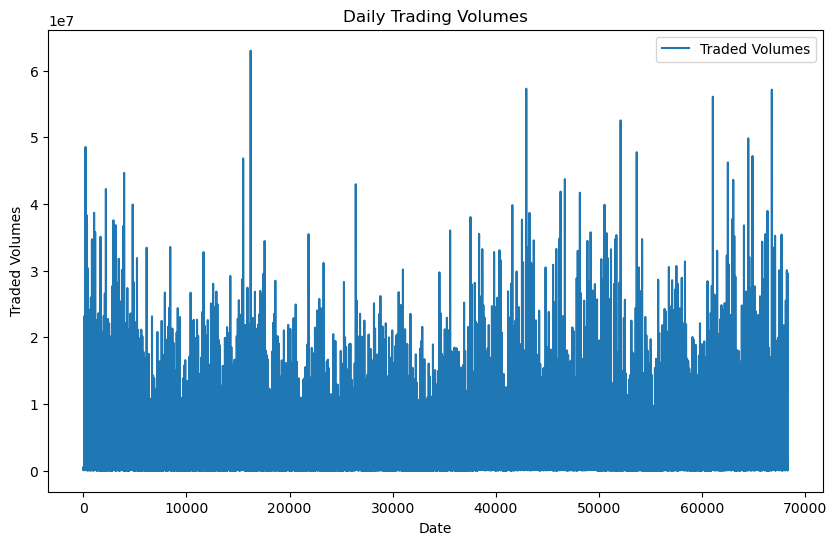

In [4]:
#plot all the data
plt.figure(figsize=(10, 6))
plt.plot(range(len(raw_pdf)), raw_pdf['volume'], label='Traded Volumes')
plt.xlabel('Date')
plt.ylabel('Traded Volumes')
plt.title('Daily Trading Volumes')
plt.legend()
plt.show()

Peaks can be seen at the closing price location.

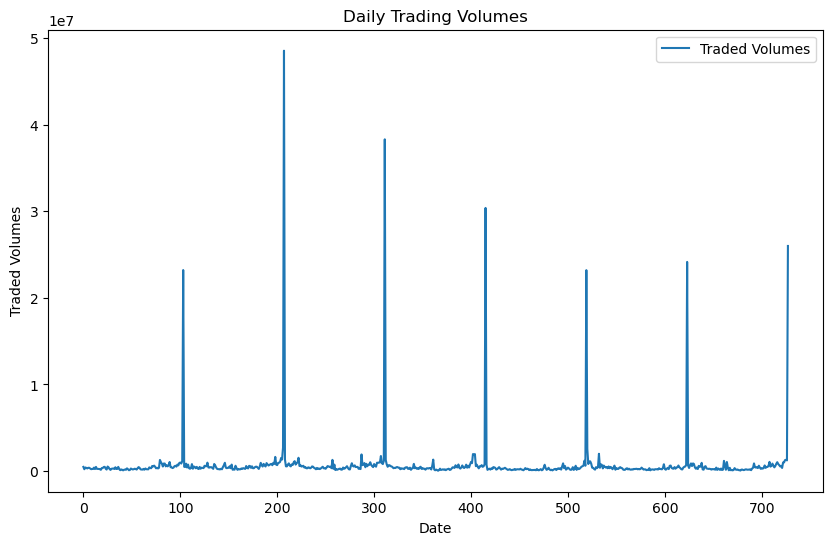

In [5]:
#plot subset of the data
ndays = 7
recent = raw_pdf.head(104*ndays)
plt.figure(figsize=(10, 6))
plt.plot(recent.index, recent['volume'], label='Traded Volumes')
plt.xlabel('Date')
plt.ylabel('Traded Volumes')
plt.title('Daily Trading Volumes')
plt.legend()
plt.show()

In [ ]:
ndays = 7
short_pdf = raw_pdf[:104*ndays]

plt.figure(figsize=(10, 6))
plt.plot(short_pdf.index, short_pdf['cum_volume'], label='Traded Volumes')
plt.xlabel('Date')
plt.ylabel('Traded Volumes')
plt.title('Daily Trading Volumes')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
train_window = 3*104
test_window = (3+1)*104
X_train, X_test = raw_pdf[0:train_window], raw_pdf[train_window:test_window]
X_total = raw_pdf[0:test_window]
model = SARIMAX(X_train['cum_volume'],  
                order = (1, 0, 1),  
                seasonal_order =(1, 1, [], 12))
#model = ARIMA(X_train['cum_volume'], order=(1,1,1))
  
result = model.fit(disp=-) 
result.summary() 

In [ ]:
forecast = result.fittedvalues
forecast.plot(legend=True)
plt.plot(X_train.index, X_train['cum_volume'], label='Traded Volumes', linestyle = "dashed")

In [ ]:
train_prediction = result.predict(0, 4*104)
train_prediction[:104*4].plot(legend=True)
plt.plot(X_total['cum_volume'].index, X_total['cum_volume'], label='Traded Volumes', linestyle = "dashed")


**Test1**

Try to predict the time series after diff of the logs transformation

/home/gael/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rate pdf min-6.860658840938789, max 6.595283046939726, mean-0.00017765803086456668


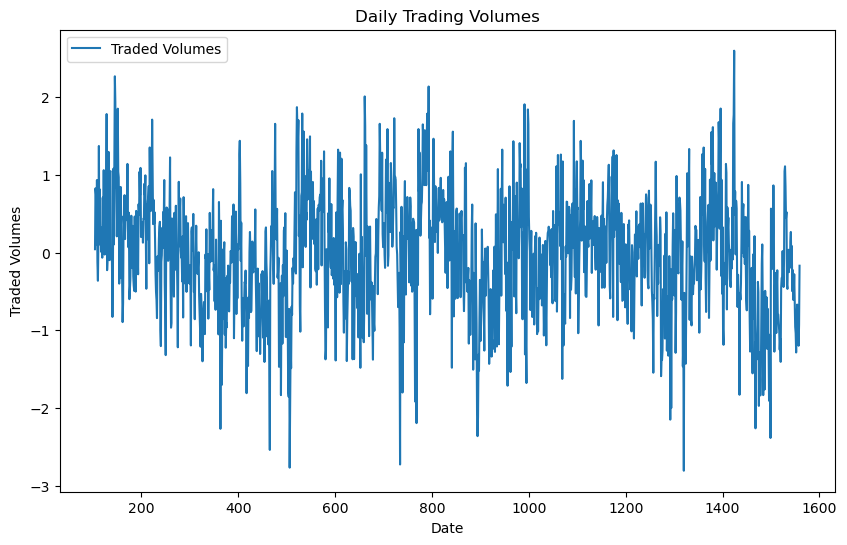

In [8]:
raw_pdf.sort_index(inplace=True)
raw_pdf['volume_yesterday'] = raw_pdf['volume'].shift(104)
raw_pdf['rate'] = np.log(raw_pdf['volume']) - np.log(raw_pdf['volume_yesterday'])
#remove nans
rate_pdf = raw_pdf[~raw_pdf.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

print(f'Rate pdf min{rate_pdf["rate"].min()}, max {rate_pdf["rate"].max()}, mean{rate_pdf["rate"].mean()}')

#plot all the data
ndays = 14
short_pdf = rate_pdf[:104*ndays]
plt.figure(figsize=(10, 6))
plt.plot(short_pdf.index, short_pdf['rate'], label='Traded Volumes')
plt.xlabel('Date')
plt.ylabel('Traded Volumes')
plt.title('Daily Trading Volumes')
plt.legend()
plt.show()

In [10]:
#Split data into train and test
n_window = 3
start_train_window = 0
end_train_window =  104*n_window + start_train_window 
end_test_window = end_train_window + 104
print(f'{end_train_window}')
X_train, X_test = rate_pdf[start_train_window:end_train_window], rate_pdf[end_train_window:end_test_window]
X_total = rate_pdf[start_train_window: end_test_window]

312


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(X_train['rate'],  
                            model ='additive',
                            period = 104)

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(X_train['rate'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plot_acf(X_train['rate'].dropna(), lags=20)
plot_pacf(X_train['rate'].dropna(), lags=20)
plt.show()

In [ ]:
adf_result = adfuller(X_test['rate'])
kpss_result = kpss(X_test['rate'])
print(f"ADF p-value: {adf_result[1]:.4f}")
print(f"KPSS p-value: {kpss_result[1]:.4f}")

/home/gael/miniconda3/envs/KP_tech_interview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gael/miniconda3/envs/KP_tech_interview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gael/miniconda3/envs/KP_tech_interview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/gael/miniconda3/envs/KP_tech_interview/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gael/miniconda3/envs/

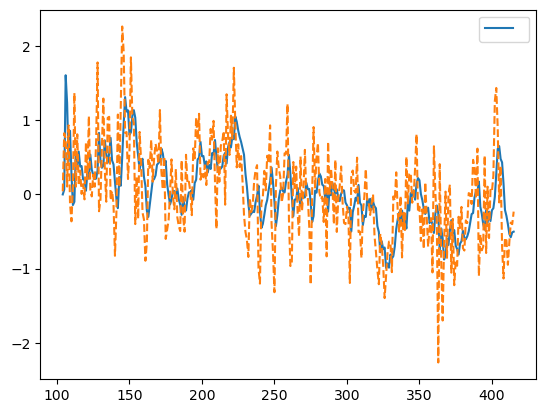

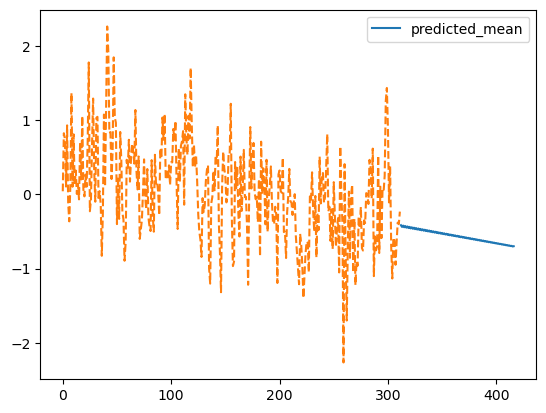

In [11]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.arima.model import ARIMA
  
model = ARIMA(X_train['rate'],  order = (1, 2, 3))
#model = SARIMAX(X_train['rate'],  order = (10, 2, 3),  seasonal_order =(5, 2, [], 12))
  
result = model.fit() 
result.summary() 

plt.figure(0)
forecast = result.fittedvalues
forecast.plot(legend=True)
plt.plot(X_train.index, X_train['rate'], label='Traded Volumes', linestyle = "dashed")

plt.figure(1)
train_prediction = result.predict(end_train_window, end_test_window)
train_prediction.plot(legend=True)
plt.plot(range(len(X_train['rate'])), X_train['rate'], label='Traded Volumes', linestyle = "dashed")